In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

import datetime

In [2]:
df = pd.read_csv('../data/interim/salary_skill_cleaned.csv')
df.head()

,Unnamed: 0,occupation,skill,importance,location,state,salary
0,0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [3]:
skills = df.pivot_table(values='importance',index=['occupation', 'location', 'salary'],columns='skill').reset_index()
skills.head()

skill,occupation,location,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
0,Accountants and Auditors,Abilene,70550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
1,Accountants and Auditors,Aguadilla-Isabela,29630.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
2,Accountants and Auditors,Akron,75550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
3,Accountants and Auditors,Albany,63940.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
4,Accountants and Auditors,Albany,70280.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75


In [4]:
#skills = skills.groupby('occupation').mean()
#skills['salary'] = skills['salary'].round()
#skills.head()

In [5]:
skills.shape

(136400, 38)

In [6]:
# Drop Installation, Equipment Selection, Equipment Maintenance, and Repairing (from EDA)
skills.drop(columns=['location','Installation', 'Equipment Selection', 'Equipment Maintenance', 'Repairing'], inplace=True)
skills.set_index('occupation', inplace=True)
skills.columns

Index(['salary', 'Active Learning', 'Active Listening',
       'Complex Problem Solving', 'Coordination', 'Critical Thinking',
       'Instructing', 'Judgment and Decision Making', 'Learning Strategies',
       'Management of Financial Resources', 'Management of Material Resources',
       'Management of Personnel Resources', 'Mathematics', 'Monitoring',
       'Negotiation', 'Operation and Control', 'Operations Analysis',
       'Operations Monitoring', 'Persuasion', 'Programming',
       'Quality Control Analysis', 'Reading Comprehension', 'Science',
       'Service Orientation', 'Social Perceptiveness', 'Speaking',
       'Systems Analysis', 'Systems Evaluation', 'Technology Design',
       'Time Management', 'Troubleshooting', 'Writing'],
      dtype='object', name='skill')

In [7]:
skills.shape

(136400, 32)

# Train/Test Split

In [8]:
len(skills) * .7, len(skills) * .3

(95480.0, 40920.0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(skills.drop(columns='salary'), 
                                                    skills.salary, test_size=0.3, 
                                                    random_state=47)

In [10]:
X_train.shape, X_test.shape

((95480, 31), (40920, 31))

In [11]:
y_train.shape, y_test.shape

((95480,), (40920,))

In [12]:
X_train.dtypes

skill
Active Learning                      float64
Active Listening                     float64
Complex Problem Solving              float64
Coordination                         float64
Critical Thinking                    float64
Instructing                          float64
Judgment and Decision Making         float64
Learning Strategies                  float64
Management of Financial Resources    float64
Management of Material Resources     float64
Management of Personnel Resources    float64
Mathematics                          float64
Monitoring                           float64
Negotiation                          float64
Operation and Control                float64
Operations Analysis                  float64
Operations Monitoring                float64
Persuasion                           float64
Programming                          float64
Quality Control Analysis             float64
Reading Comprehension                float64
Science                              float64
Serv

In [13]:
X_test.dtypes

skill
Active Learning                      float64
Active Listening                     float64
Complex Problem Solving              float64
Coordination                         float64
Critical Thinking                    float64
Instructing                          float64
Judgment and Decision Making         float64
Learning Strategies                  float64
Management of Financial Resources    float64
Management of Material Resources     float64
Management of Personnel Resources    float64
Mathematics                          float64
Monitoring                           float64
Negotiation                          float64
Operation and Control                float64
Operations Analysis                  float64
Operations Monitoring                float64
Persuasion                           float64
Programming                          float64
Quality Control Analysis             float64
Reading Comprehension                float64
Science                              float64
Serv

# Baseline Model

In [14]:
# Use the mean as a baseline model
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[61026.75408463]])

In [15]:
# Predictions, train and test
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = dumb_reg.predict(X_test)

In [16]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -3.216802713090772e-08)

In [17]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(24533.935816246674, 24364.485698314547)

In [18]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1072480617.7045026, 1062808234.5288912)

# Linear Regression

In [19]:
# Linear Regression
lm = LinearRegression().fit(X_train, y_train)

In [20]:
# Predictions, train and test
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [21]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.5768095484135022, 0.5849122676769242)

In [22]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(14826.680389162088, 14654.471828288393)

In [23]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(453863556.92413455, 441158645.7736859)

# Pipeline

In [24]:
pipeline = make_pipeline(SelectKBest(f_regression), LinearRegression())

In [25]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000027DC0679790>)),
                ('linearregression', LinearRegression())])

In [26]:
y_tr_pred = pipeline.predict(X_train)
y_te_pred = pipeline.predict(X_test)

In [27]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.5078524287934757, 0.5130195936060382)

In [28]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(15764.672502052788, 15600.375368794907)

In [29]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(527818731.1693439, 517566769.3206267)

In [30]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

# Cross Validation

In [31]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [32]:
lr_grid_cv = GridSearchCV(pipeline, param_grid=grid_params, cv=5, n_jobs=-1)

In [33]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000027DC0679790>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [34]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [35]:
lr_grid_cv.best_params_

{'selectkbest__k': 30}

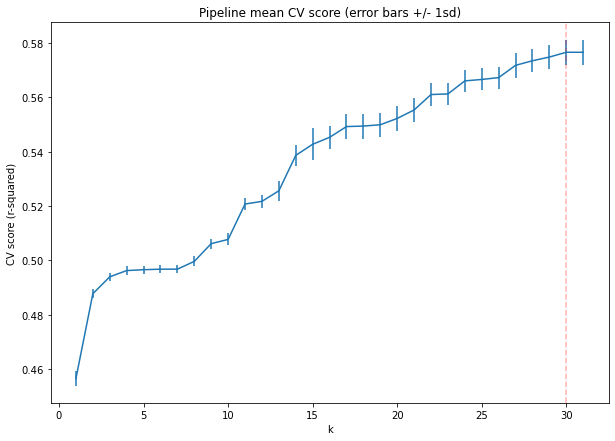

In [36]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.3)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [37]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [38]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important

skill
Management of Financial Resources    17435.139942
Judgment and Decision Making         14216.754796
Persuasion                           13739.202693
Critical Thinking                    11138.944552
Science                              10948.870211
Active Learning                      10331.643605
Time Management                       9325.618494
Reading Comprehension                 7346.724888
Monitoring                            6774.436654
Management of Personnel Resources     6226.131138
Systems Evaluation                    4356.854234
Speaking                              3836.187489
Complex Problem Solving               2353.800975
Operation and Control                  -89.673808
Social Perceptiveness                 -165.499880
Programming                           -397.142571
Technology Design                     -618.979324
Operations Analysis                   -721.649162
Troubleshooting                       -903.535289
Systems Analysis                     -1273.9

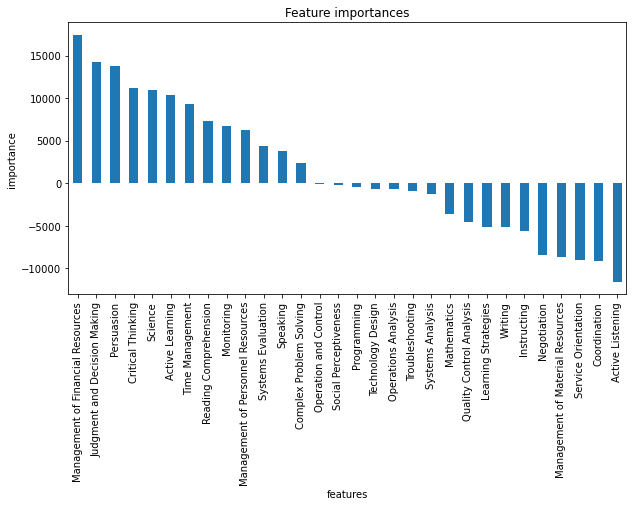

In [39]:
plt.subplots(figsize=(10, 5))
most_important.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importances');

In [40]:
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()